# Power Laws

## Get Data

In [1]:
import pandas as pd
from coinmetrics.api_client import CoinMetricsClient
import logging
from scipy.stats import linregress, lognorm
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Initialize Coin Metrics API client
client = CoinMetricsClient()

# Define the asset, metric, and time range
asset = 'btc'
metric = 'ReferenceRate'
start_time = '2010-09-01'
end_time = '2024-08-31'
frequency = '1d'

# Fetch the metric data for the specified asset and time range
logging.info("Fetching BTC ReferenceRate...")
df = client.get_asset_metrics(
    assets=asset,
    metrics=[metric],
    frequency=frequency,
    start_time=start_time,
    end_time=end_time
).to_dataframe()

# Rename the 'ReferenceRate' column to 'Close'
df = df.rename(columns={metric: 'Close'})

# Set 'time' as the index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Display the first few rows
df.head()

2024-08-31 20:22:10 INFO     Fetching BTC ReferenceRate...
2024-08-31 20:22:12 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2024-08-31 20:22:20 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2024-08-31 20:22:28 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2024-08-31 20:22:36 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits


,asset,Close
time,,
2010-09-01 00:00:00+00:00,btc,0.06
2010-09-02 00:00:00+00:00,btc,0.062025
2010-09-03 00:00:00+00:00,btc,0.0634
2010-09-04 00:00:00+00:00,btc,0.06085
2010-09-05 00:00:00+00:00,btc,0.062178


## Create Days

In [2]:
# Ensure 'start_date' is timezone-naive
start_date = pd.Timestamp(start_time).tz_localize(None)

# Ensure the index of df is timezone-naive
df.index = df.index.tz_localize(None)

# Create 'Days' column
df['Days'] = (df.index - start_date).days
df = df.tail(-1)

df = df.drop(columns=['asset'])
# Convert the 'Close' and 'Days' columns to numeric types, coercing errors to NaN
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Days'] = pd.to_numeric(df['Days'], errors='coerce')

df = df.dropna(subset=['Close', 'Days'])
df

,Close,Days
time,,
2010-09-02,0.062025,1
2010-09-03,0.0634,2
2010-09-04,0.06085,3
2010-09-05,0.062178,4
2010-09-06,0.06165,5
...,...,...
2024-08-27,62983.442773,5109
2024-08-28,59548.007622,5110
2024-08-29,59100.774755,5111


## Create log_days and log_close

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import linregress

# Convert 'Days' to Float64
df['Days'] = pd.to_numeric(df['Days'], errors='coerce').astype('float64')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce').astype('float64')

df['log_days'] = np.log(df['Days'])
df['log_close'] = np.log(df['Close'])

# Convert 'log_days' to Float64
df['log_days'] = pd.to_numeric(df['log_days'], errors='coerce').astype('float64')
df['log_close'] = pd.to_numeric(df['log_close'], errors='coerce').astype('float64')

df

,Close,Days,log_days,log_close
time,,,,
2010-09-02,0.062025,1.0,0.000000,-2.780221
2010-09-03,0.063400,2.0,0.693147,-2.758291
2010-09-04,0.060850,3.0,1.098612,-2.799343
2010-09-05,0.062178,4.0,1.386294,-2.777750
2010-09-06,0.061650,5.0,1.609438,-2.786282
...,...,...,...,...
2024-08-27,62983.442773,5109.0,8.538759,11.050627
2024-08-28,59548.007622,5110.0,8.538955,10.994538
2024-08-29,59100.774755,5111.0,8.539150,10.986999


## Fitting

### Polynomial

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Prepare the data for fitting
X = df['log_days'].values.reshape(-1, 1)  # Reshape for sklearn
y = df['log_close'].values

# Set up the RANSAC regressor with a cubic polynomial model
ransac = RANSACRegressor(
    estimator=make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
    min_samples=0.9, 
    residual_threshold=5.0, 
    random_state=0
)

# Fit the model
ransac.fit(X, y)

# Predict the fitted values (in log space) using the model and add them to the DataFrame
df['log_fitted'] = ransac.predict(X)
df['fitted'] = np.exp(df['log_fitted'])

# Drop the first year's worth of data
df = df[df.index >= df.index[0] + pd.DateOffset(years=1)]

# Recompute X and y after dropping rows
X = df['log_days'].values.reshape(-1, 1)
y = df['log_close'].values

# Calculate the R-squared value
r_value = r2_score(y, df['log_fitted'])

# Display the first few rows of the resulting DataFrame and the R-squared value
df.head(), r_value

(               Close   Days  log_days  log_close  log_fitted    fitted
 time                                                                  
 2011-09-02  8.234282  366.0  5.902633   2.108306    1.290595  3.634949
 2011-09-03  8.621424  367.0  5.905362   2.154250    1.297158  3.658885
 2011-09-04  8.449653  368.0  5.908083   2.134125    1.303710  3.682936
 2011-09-05  8.203471  369.0  5.910797   2.104557    1.310251  3.707104
 2011-09-06  7.597333  370.0  5.913503   2.027797    1.316781  3.731389,
 0.9387032677223787)

## Calculate upper and lower bounds

In [5]:
# Calculate residuals
df['residuals'] = df['log_close'] - df['log_fitted']

# Shift residuals to make them all positive for log-normal fitting
shifted_residuals = df['residuals'] - df['residuals'].min() + 1e-9  # Shift by the minimum value plus a small epsilon

# Fit to a log-normal distribution
shape, loc, scale = lognorm.fit(shifted_residuals, floc=0)

# Calculate deviation levels with adjusted scaling
deviation_scale = 1.5  # Adjust this scale to control how wide the bounds are

df['upper_bound'] = np.exp(df['log_fitted'] + deviation_scale * lognorm.ppf(0.34, shape, loc=loc, scale=scale))
df['lower_bound'] = np.exp(df['log_fitted'] - deviation_scale * lognorm.ppf(0.34, shape, loc=loc, scale=scale))
df

/var/folders/b8/z397yjvn3xj72ht4tz6zzjs00000gn/T/ipykernel_71200/1424972503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['residuals'] = df['log_close'] - df['log_fitted']
/var/folders/b8/z397yjvn3xj72ht4tz6zzjs00000gn/T/ipykernel_71200/1424972503.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['upper_bound'] = np.exp(df['log_fitted'] + deviation_scale * lognorm.ppf(0.34, shape, loc=loc, scale=scale))
/var/folders/b8/z397yjvn3xj72ht4tz6zzjs00000gn/T/ipykernel_71200/1424972503.py:14: Setting

,Close,Days,log_days,log_close,log_fitted,fitted,residuals,upper_bound,lower_bound
time,,,,,,,,,
2011-09-02,8.234282,366.0,5.902633,2.108306,1.290595,3.634949,0.817711,8.906500,1.483507
2011-09-03,8.621424,367.0,5.905362,2.154250,1.297158,3.658885,0.857092,8.965147,1.493276
2011-09-04,8.449653,368.0,5.908083,2.134125,1.303710,3.682936,0.830415,9.024079,1.503092
2011-09-05,8.203471,369.0,5.910797,2.104557,1.310251,3.707104,0.794306,9.083296,1.512955
2011-09-06,7.597333,370.0,5.913503,2.027797,1.316781,3.731389,0.711017,9.142800,1.522866
...,...,...,...,...,...,...,...,...,...
2024-08-27,62983.442773,5109.0,8.538759,11.050627,11.187657,72233.352383,-0.137030,176989.076471,29480.108606
2024-08-28,59548.007622,5110.0,8.538955,10.994538,11.188692,72308.133440,-0.194154,177172.308036,29510.628492
2024-08-29,59100.774755,5111.0,8.539150,10.986999,11.189726,72382.980866,-0.202727,177355.702221,29541.175465


## Create future dates

In [6]:
# Project the future (let's assume 365 days into the future)
future_days = np.arange(df['Days'].max() + 1, df['Days'].max() + 366)
future_log_days = np.log(future_days)
future_log_fitted = ransac.predict(future_log_days.reshape(-1, 1))
future_fitted = np.exp(future_log_fitted)

# Generate future dates starting from one day after the last available date
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')

## Plot

/var/folders/b8/z397yjvn3xj72ht4tz6zzjs00000gn/T/ipykernel_71200/126849320.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['upper_bound'] = np.exp(df['log_fitted'] + deviation_scale * lognorm.ppf(0.5, shape, loc=loc, scale=scale))
/var/folders/b8/z397yjvn3xj72ht4tz6zzjs00000gn/T/ipykernel_71200/126849320.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lower_bound'] = np.exp(df['log_fitted'] - deviation_scale * lognorm.ppf(0.5, shape, loc=loc, scale=scale))


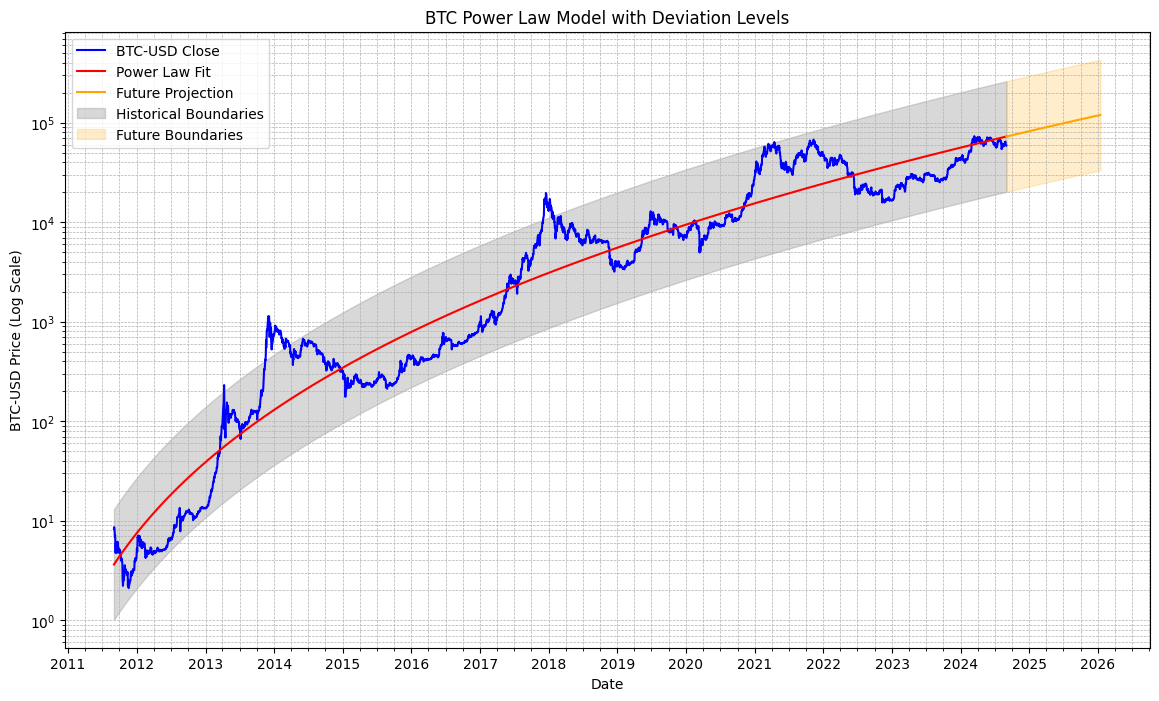

R-squared value of the fit: 0.9387


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import lognorm
import numpy as np
from sklearn.metrics import r2_score

# Assume df and model have been defined and calculated in previous parts
# Define the number of days into the future for projections
future_days = 500

# Create a range of future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_days + 1, freq='D')[1:]

# Create future projections DataFrame
future_df = pd.DataFrame(index=future_dates)
future_df['Days'] = np.arange(df['Days'].max() + 1, df['Days'].max() + 1 + future_days)
future_df['log_days'] = np.log(future_df['Days'])

# Compute future fitted values using the RANSAC model
future_df['log_fitted'] = ransac.predict(future_df['log_days'].values.reshape(-1, 1))
future_df['fitted'] = np.exp(future_df['log_fitted'])

# Assuming deviation_scale, shape, loc, scale are already defined for bounds calculation
future_df['upper_bound'] = np.exp(future_df['log_fitted'] + deviation_scale * lognorm.ppf(0.5, shape, loc=loc, scale=scale))
future_df['lower_bound'] = np.exp(future_df['log_fitted'] - deviation_scale * lognorm.ppf(0.5, shape, loc=loc, scale=scale))

# Also calculate the bounds for the historical data
df['upper_bound'] = np.exp(df['log_fitted'] + deviation_scale * lognorm.ppf(0.5, shape, loc=loc, scale=scale))
df['lower_bound'] = np.exp(df['log_fitted'] - deviation_scale * lognorm.ppf(0.5, shape, loc=loc, scale=scale))

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Close'], label='BTC-USD Close', color='blue')
plt.plot(df.index, df['fitted'], label='Power Law Fit', color='red')
plt.plot(future_df.index, future_df['fitted'], label='Future Projection', color='orange')

# Plot upper and lower bounds
plt.fill_between(df.index, df['lower_bound'], df['upper_bound'], color='gray', alpha=0.3, label='Historical Boundaries')
plt.fill_between(future_df.index, future_df['lower_bound'], future_df['upper_bound'], color='orange', alpha=0.2, label='Future Boundaries')

# Add gridlines for years and quarters
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to January 1st of each year
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(4, 7, 10)))  # Set minor ticks to the start of each quarter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as full year

plt.legend()
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('BTC-USD Price (Log Scale)')
plt.title('BTC Power Law Model with Deviation Levels')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Output R-squared value
r_value = r2_score(df['log_close'], df['log_fitted'])
print(f"R-squared value of the fit: {r_value:.4f}")


In [22]:
future_df.tail(30)

,Days,log_days,log_fitted,fitted,upper_bound,lower_bound
2025-12-15,5584.0,8.627661,11.662826,116171.926161,417193.438634,32349.301734
2025-12-16,5585.0,8.627840,11.663794,116284.381942,417597.286755,32380.616236
2025-12-17,5586.0,8.628019,11.664761,116396.931325,418001.471017,32411.956802
2025-12-18,5587.0,8.628198,11.665729,116509.574377,418405.991658,32443.323452
2025-12-19,5588.0,8.628377,11.666696,116622.311162,418810.848912,32474.716202
2025-12-20,5589.0,8.628556,11.667663,116735.141747,419216.043018,32506.135072
2025-12-21,5590.0,8.628735,11.668630,116848.066197,419621.574211,32537.580080
2025-12-22,5591.0,8.628913,11.669597,116961.084579,420027.442728,32569.051244
2025-12-23,5592.0,8.629092,11.670563,117074.196959,420433.648805,32600.548582
2025-12-24,5593.0,8.629271,11.671530,117187.403401,420840.192681,32632.072114


## % Integral and Maximum Change

In [9]:
import pandas as pd
import numpy as np
from scipy.integrate import simpson  # For numerical integration

# 1. Calculate the relative % change of the BTC close price from the fitted line
df.loc[:, 'relative_pct_change'] = (df['Close'] - df['fitted']) / df['fitted'] * 100

# 2. Identify sections where the BTC close price is greater than the fitted line for at least 3 weeks straight
# We need to identify consecutive periods where the relative_pct_change is positive for at least 21 days (3 weeks)
df.loc[:, 'above_fitted'] = df['relative_pct_change'] > 0

# Find the start and end indices of these periods
sections = []
start_idx = None

for i in range(len(df)):
    if df['above_fitted'].iloc[i]:
        if start_idx is None:
            start_idx = i
    else:
        if start_idx is not None:
            if i - start_idx >= 21:  # Ensure it's at least 21 days (3 weeks)
                sections.append((start_idx, i - 1))
            start_idx = None

# In case the last segment goes to the end of the dataframe
if start_idx is not None and len(df) - start_idx >= 21:
    sections.append((start_idx, len(df) - 1))

# 3. Calculate the integral of the relative % change and the maximum % change for each identified section
results = []

for start, end in sections:
    time_points = np.arange(end - start + 1)  # Create an array of time points for integration
    values = df['relative_pct_change'].iloc[start:end + 1].values
    integral = simpson(values, x=time_points)  # Explicitly specify the x argument
    
    # Only keep sections where the integral is greater than 10,000%
    if integral >= 10000:
        max_pct_change = values.max()  # Calculate the maximum % change for the section
        results.append((start, end, integral, max_pct_change))

# Display the results
for start, end, integral, max_pct_change in results:
    print(f"Section from {df.index[start]} to {df.index[end]}: Integral of relative % change = {integral:.4f}, Maximum % change = {max_pct_change:.2f}%")

Section from 2013-07-11 00:00:00 to 2014-12-16 00:00:00: Integral of relative % change = 93355.0923, Maximum % change = 855.02%
Section from 2017-07-21 00:00:00 to 2018-11-19 00:00:00: Integral of relative % change = 58902.5657, Maximum % change = 549.99%
Section from 2020-11-06 00:00:00 to 2022-05-18 00:00:00: Integral of relative % change = 61247.0864, Maximum % change = 261.06%


/var/folders/b8/z397yjvn3xj72ht4tz6zzjs00000gn/T/ipykernel_71200/41381015.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'relative_pct_change'] = (df['Close'] - df['fitted']) / df['fitted'] * 100
/var/folders/b8/z397yjvn3xj72ht4tz6zzjs00000gn/T/ipykernel_71200/41381015.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'above_fitted'] = df['relative_pct_change'] > 0
